In [ ]:
from scipy.fft import fft, ifft

This notebook follows the tutorial found here https://www.youtube.com/watch?v=sHWKN5dakPw


In [2]:
### Import Dependancies

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

import random
import math
import time

from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')

from google.colab import files
from google.colab import drive
drive.mount('/Drive')

from scipy.fft import fft, ifft

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Drive


Import Data Set


In [133]:
whoURL = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'
who_data = pd.read_csv(whoURL)

In [134]:
who_data.tail(5)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
28847,2020-07-13,ZW,Zimbabwe,AFRO,3,985,0,18
28848,2020-07-14,ZW,Zimbabwe,AFRO,49,1034,1,19
28849,2020-07-15,ZW,Zimbabwe,AFRO,30,1064,1,20
28850,2020-07-16,ZW,Zimbabwe,AFRO,25,1089,0,20
28851,2020-07-17,ZW,Zimbabwe,AFRO,273,1362,3,23


In [135]:
# Drop rows that have missing values
print(who_data.shape)
who_data.dropna(inplace=True)
print(who_data.shape)

(28852, 8)
(28726, 8)


In [136]:
# reconfigure the data so we have just deaths
cumulative_deaths = who_data.filter(['Date_reported', ' Cumulative_deaths'], axis = 1)
cumulative_deaths = cumulative_deaths.groupby('Date_reported', as_index=False).sum()
cumulative_deaths.head(3)

,Date_reported,Cumulative_deaths
0,2020-01-11,1
1,2020-01-12,1
2,2020-01-13,1


In [137]:
# reconfigure the data so we have just cases
cumulative_cases = who_data.filter(['Date_reported', ' Cumulative_cases'], axis = 1)
cumulative_cases = cumulative_cases.groupby('Date_reported', as_index=False).sum()
cumulative_cases.tail(3)

,Date_reported,Cumulative_cases
186,2020-07-15,13151805
187,2020-07-16,13377890
188,2020-07-17,13615561


In [138]:
earliest_reported = who_data['Date_reported'].min()
earliest_reported
last_updated = who_data['Date_reported'].max()
last_updated


'2020-07-17'

In [139]:
dates = cumulative_cases['Date_reported']
dates

0      2020-01-11
1      2020-01-12
2      2020-01-13
3      2020-01-14
4      2020-01-15
          ...    
184    2020-07-13
185    2020-07-14
186    2020-07-15
187    2020-07-16
188    2020-07-17
Name: Date_reported, Length: 189, dtype: object

In [140]:
world_cases = np.array(cumulative_cases[' Cumulative_cases'])
world_cases

array([      41,       41,       42,       43,       43,       43,
             48,       65,      125,      203,      296,      450,
            583,      854,     1323,     2021,     2806,     4595,
           6076,     7836,     9846,    11961,    14559,    17391,
          20649,    24563,    28284,    31486,    34899,    37568,
          40623,    43109,    45174,    60387,    64455,    67187,
          69277,    71438,    73431,    75287,    75773,    76817,
          77926,    78942,    79566,    80392,    81316,    82685,
          84133,    85959,    87850,    90131,    92463,    94663,
          97440,   101240,   105166,   108904,   112951,   117439,
         123964,   130483,   140126,   151636,   163489,   175280,
         190104,   208533,   232509,   265401,   288849,   298185,
         331907,   391864,   422395,   478118,   519722,   582513,
         644250,   701942,   760029,   833723,   907004,   982209,
        1062266,  1142094,  1219079,  1288420,  1362610,  1445

In [141]:
total_deaths = np.array(cumulative_deaths[' Cumulative_deaths'])
total_deaths

array([     1,      1,      1,      1,      1,      1,      2,      2,
            3,      4,      6,      9,     17,     25,     41,     56,
           80,    106,    132,    170,    213,    259,    305,    362,
          426,    492,    565,    638,    724,    813,    910,   1018,
         1115,   1371,   1384,   1528,   1670,   1776,   1874,   2012,
         2130,   2250,   2363,   2464,   2628,   2711,   2772,   2815,
         2874,   2942,   2987,   3074,   3154,   3245,   3346,   3459,
         3554,   3800,   4005,   4288,   4647,   5005,   5492,   5926,
         6659,   7399,   8233,   9307,  10528,  12086,  13849,  14660,
        16709,  18989,  21380,  24247,  26945,  30330,  33771,  37172,
        40842,  45088,  50019,  54899,  61545,  67344,  72347,  77732,
        84611,  90963,  98408, 105301, 111509, 117128, 122584, 128762,
       136626, 149030, 155606, 162436, 167530, 172957, 179681, 186310,
       192604, 198451, 204823, 209614, 213648, 218898, 224785, 231088,
      

In [142]:
days_since_start = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases     = np.array(world_cases).reshape(-1, 1)
total_deaths    = np.array(total_deaths).reshape(-1, 1)

Future Forecasting


In [143]:
days_in_future  = 30  # WE WILL GO 30 DAYS INTO THE FUTURE
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates  = future_forecast[:-30]

In [144]:
start = earliest_reported
start_date = datetime.datetime.strptime(start, '%Y-%m-%d')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime( '%m/%d/%Y'))

Machine Learning

In [145]:
# SPLIT THE DATA
X_train_confirmed, X_test_confirmed,y_train_confirmed, y_test_confirmed = train_test_split(days_since_start, world_cases, test_size=0.35, shuffle=True)


In [146]:
# SET THE RANGES FOR PARAMS
kernel = ['poly', 'sigmoid', 'rbf', 'linear']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma, 'epsilon':epsilon, 'shrinking':shrinking}

In [147]:
# BUILD THE MODEL
svm = SVR()

## HYPER TUNE THE MODEL
## Randomized search on hyper parameters.
## In contrast to GridSearchCV,
## not all parameter values are tried out, 
## but rather a fixed number of parameter 
## settings is sampled from the specified distributions. 
## The number of parameter settings that are tried is given by n_iter
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv = 3, n_jobs=-1, n_iter=30, return_train_score=True, verbose =1)
### svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'r2', cv=3, n_iter=30, n_jobs=-1, return_train_score=True, verbose=1)

In [148]:
# FIT THE MODEL
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1],
                                        'kernel': ['poly', 'sigmoid', 'rbf',
                                                   'linear'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [149]:
# FIND THE BEST PARAMS
svm_search.best_params_

{'C': 1, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'poly', 'shrinking': False}

In [150]:
# USE THE BEST PARAMS ON FUTURE DATES
svm_confirmed = svm_search.best_estimator_
svm_pred      = svm_confirmed.predict(future_forecast)

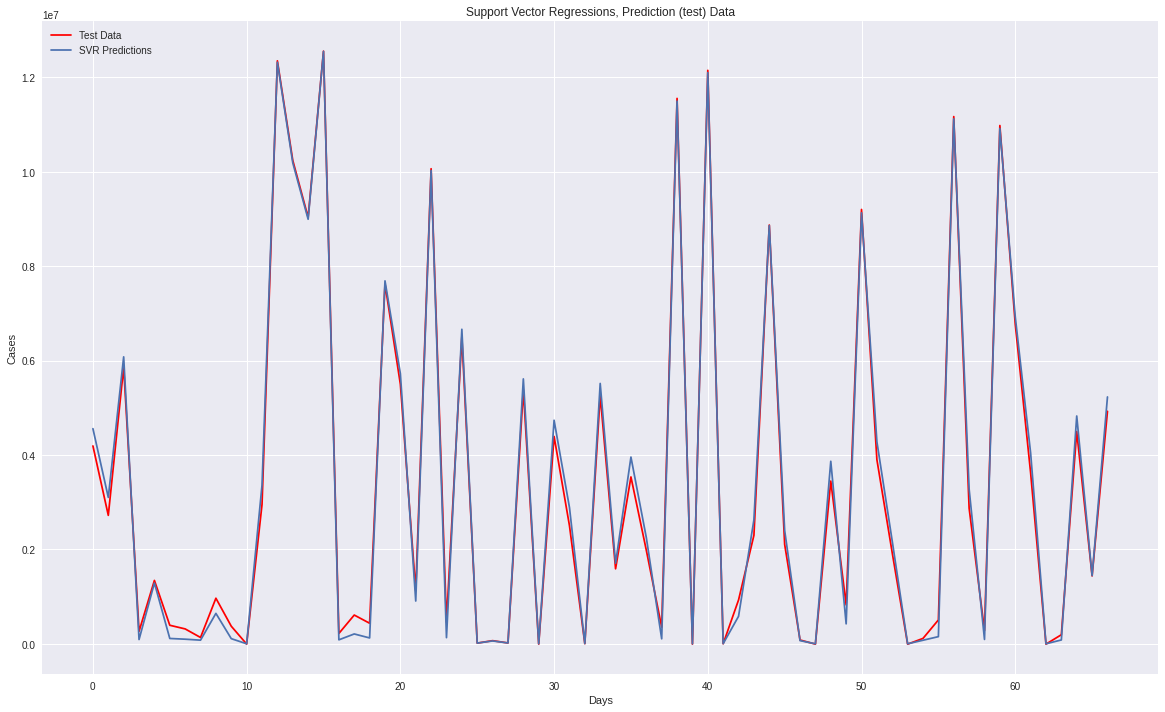

In [156]:
# CHECK AGAINST TEST DATA SET
# Check against testing data = note this is a random sample  
plt.figure(figsize=(20, 12))
svm_test_pred = svm_confirmed.predict(X_test_confirmed)

plt.plot(svm_test_pred, color='RED') #Predicted.
plt.plot(y_test_confirmed)   #Actual
plt.title('Support Vector Regressions, Prediction (test) Data')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend(['Test Data', 'SVR Predictions'], loc='upper left')



In [172]:
score = svm_confirmed.score(X_train_confirmed, y_train_confirmed)
print('All Countries - TRAINING Data Score {:2.6f}'.format(score))


All Countries - TRAINING Data Score 0.996889


In [173]:
score = svm_confirmed.score(X_test_confirmed, y_test_confirmed)
print('All Countries - TEST Data Score {:2.6f}'.format(score))


All Countries - TEST Data Score 0.996383


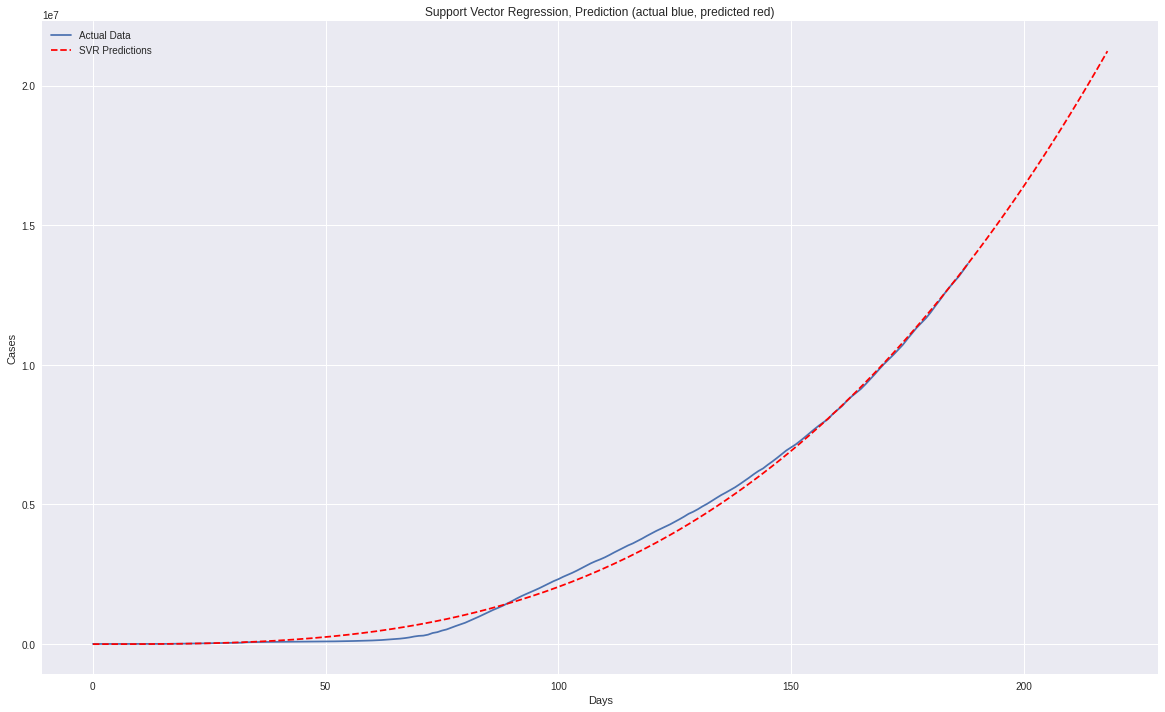

In [154]:
# PLOT ACTUAL AGAINST PREDICTED

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('Support Vector Regression, Prediction (actual blue, predicted red)')
plt.xlabel('Days')
plt.ylabel('Cases')
_ = plt.plot(future_forecast, svm_pred, linestyle='dashed', color='red')       
plt.legend(['Actual Data', 'SVR Predictions'], loc='upper left')


End of Notebook 